In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/X_test.csv
/kaggle/input/career-con-2019/X_train.csv


In [2]:
#Imports

import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import math
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')


In [3]:
#Reading from ther directory data

X_test = pd.read_csv("../input/career-con-2019/X_test.csv")
X_train = pd.read_csv("../input/career-con-2019/X_train.csv")
sample_submission = pd.read_csv("../input/career-con-2019/sample_submission.csv")
y_train = pd.read_csv("../input/career-con-2019/y_train.csv")

In [4]:
#Let look at the shape of the data
print('X_Train ',X_train.shape)
print('X_Test',X_test.shape)
print('y_train',y_train.shape)

X_Train  (487680, 13)
X_Test (488448, 13)
y_train (3810, 3)


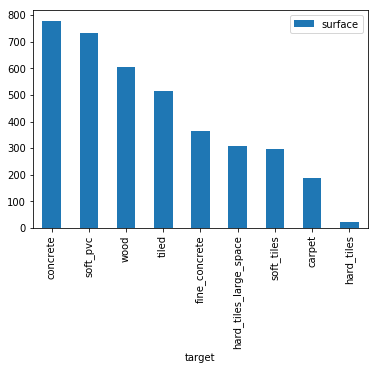

In [5]:
target = y_train['surface'].value_counts().reset_index().rename(columns={'index':'target'})

#Plotting the surface i.e labels and their count in y_train
target.plot.bar(x='target',y = 'surface')

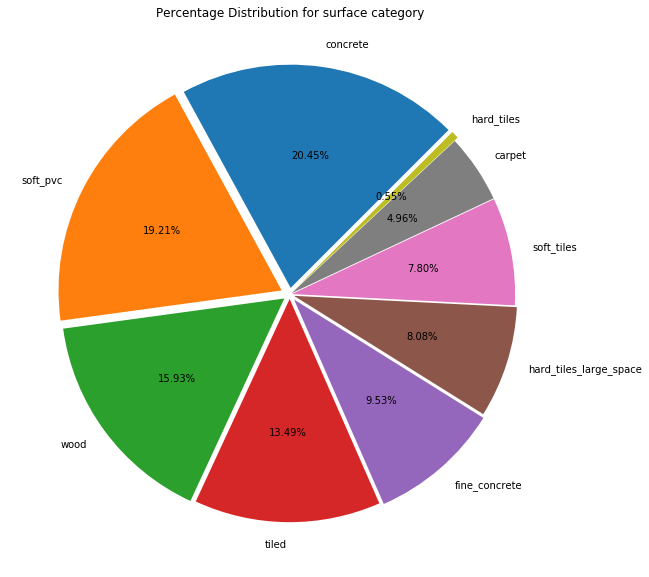

In [6]:
#This is the pie plot, where each surface in the train dataset holds how much percentage
labels = y_train['surface'].value_counts().index
values = y_train['surface'].value_counts().values
explode = [round(random.uniform(0.04,.01),2) for i in range(len(labels))]
fig = plt.figure(figsize=(10,10))
plt.axis('equal')
plt.title('Percentage Distribution for surface category')
plt.pie(values,labels = labels,radius = 1,autopct='%.2f%%',startangle=45,explode=explode)
plt.show()

Before we start plotting the features using seaborn libraries, let us see the correlation matrix. This matrix tells us relation between every parameter to every other parameter in the dataset. There are negative, positive and no-relation types of correlations.

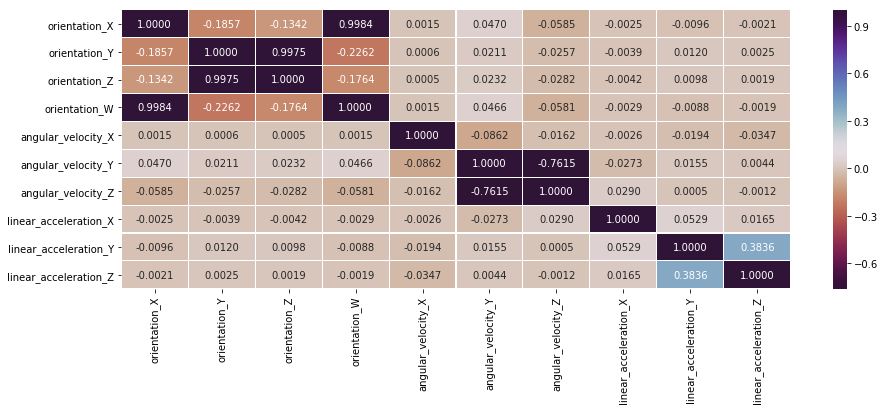

In [7]:
#Calculating the corr in the dataset

corr = X_train.corr()
fig, ax = plt.subplots(1,1, figsize = (15,5))
hm = sns.heatmap(X_train.iloc[:,3:].corr(),
                ax = ax,
                cmap = 'twilight_shifted_r',
                annot = True,
                fmt = '.4f',
                linewidths = 0.05)
fig.subplots_adjust(top=0.90)

Infered : orientation_Y and orientation_Z are highly correlated.
Also, orientation_X and orientation_W show positive correlation.
angular_velocity_Y and angular_velocity_Y are negative coorelated.
linear_acceleration_Y and linear_acceleration_Z also shows some relation.

1. Voilin Plot are the plots that combines both kde distribution and the wisker plot distribution.
2. We can easily see, what's the median and how well is the distribution formed without using kde and distplot.
3. They are also good for detecting outliers in the datasets.

Let's visualize out each features distribution

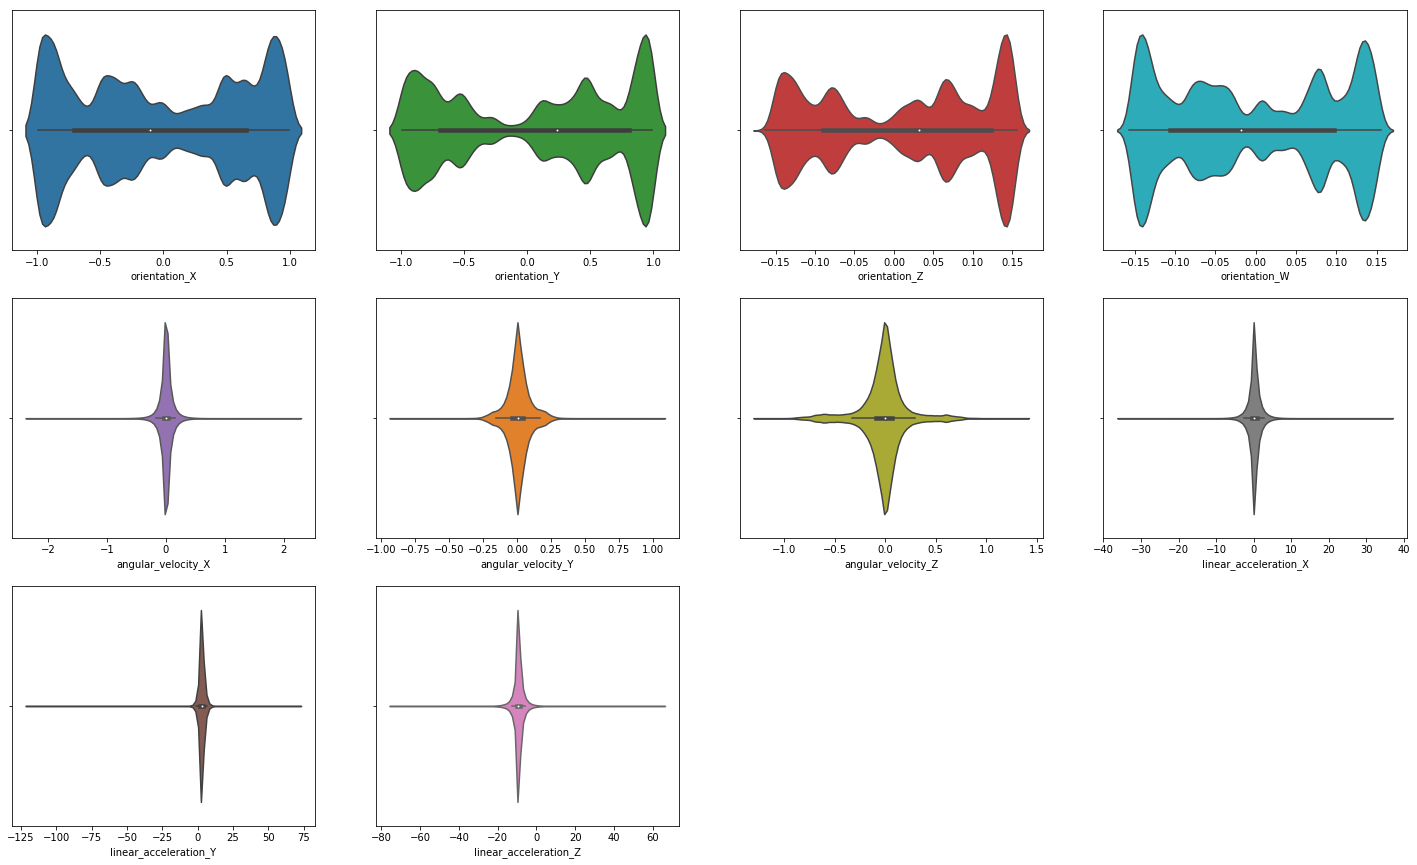

In [8]:
i= 0
color = ['tab:blue','tab:green','tab:red','tab:cyan','tab:purple','tab:orange','tab:olive','tab:gray','tab:brown','tab:pink']

fig = plt.figure(figsize=(25,15))
for col in X_train.columns[3:13]:
    plt.subplot(3,4,i+1)
    sns.violinplot(x=X_train[col],size=8,color = color[i])
    i+=1



* Clearly seen from the violin plot, the inferences concluded from correlation matrix is getting reflected.
* Another set of observation, all features are almost near zero mean and it's a good thing, we can avoid standardizing those as they lie in approx same scale range of zero mean.

Now that we looked at combine kde and distribution plot, let's look at individual plots to more about data.

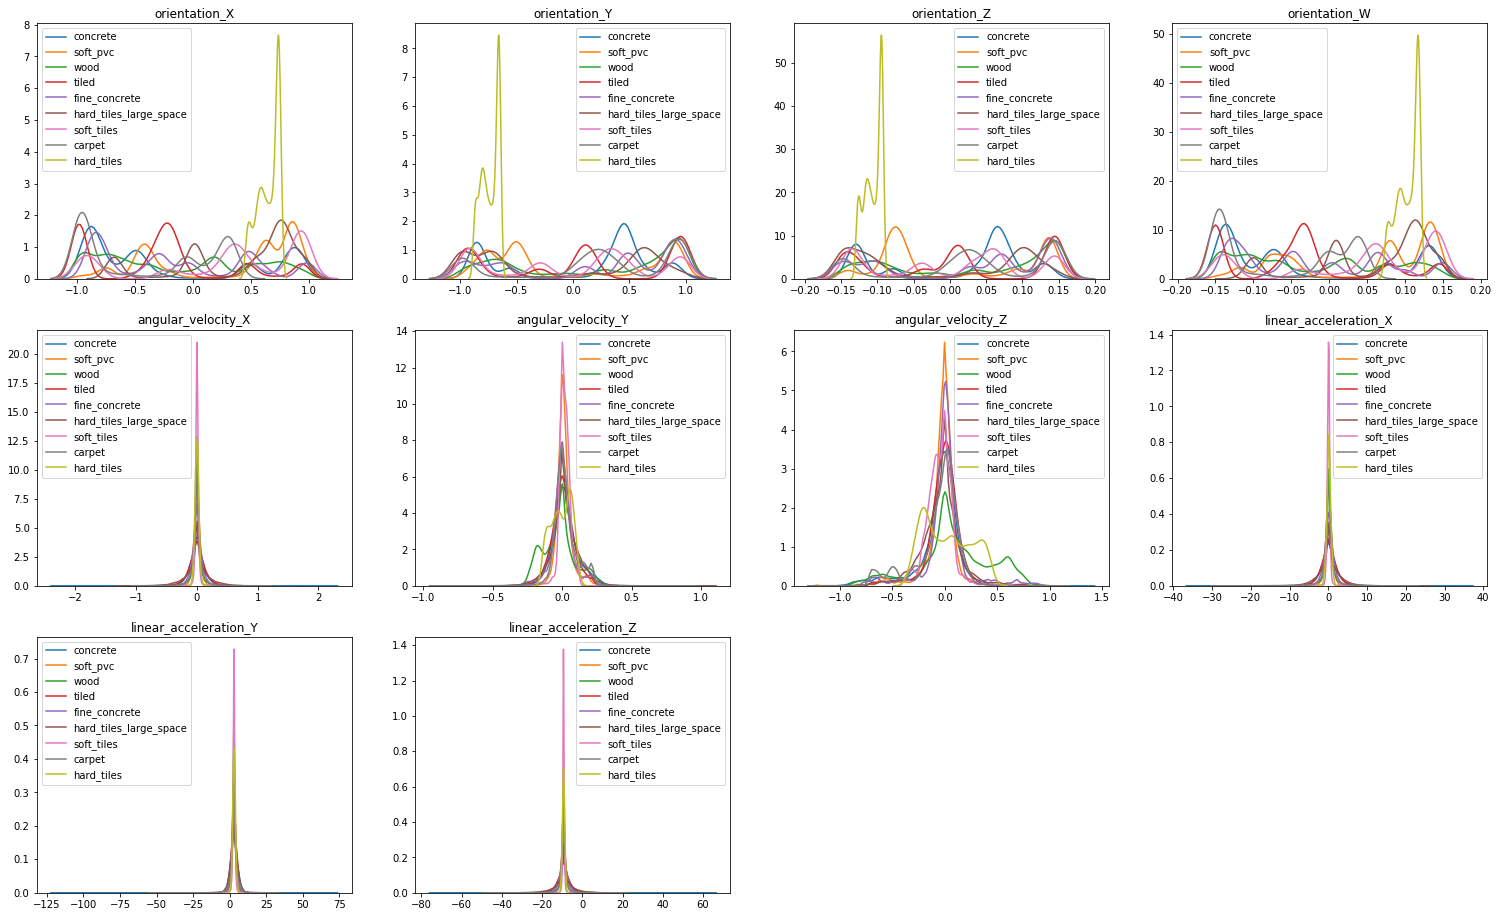

In [9]:
#Kde Plot for each col to understand the underlying data

fig = plt.figure(figsize=(26,16))
target = y_train['surface'].value_counts().index
df = X_train.merge(y_train,on='series_id',how='inner')
for i,col in enumerate(df.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in target:
        surface_df = df[df['surface'] == surface]
        sns.kdeplot(surface_df[col],label=surface)

* It can be seen for each surface type,orientation_X and orientation_W exhibit same behavior/orientation_Y and orientation_Z exhibit approx same nature.
* Now that we are done with high level observation for all columns let's dive in deeper on basis of series id.
Segregating the dataframe based on series_id

In [10]:

series_dict = {}
series_dictTest = {}

for series in X_train['series_id'].unique():
    series_dict[series] = X_train[X_train['series_id'] == series]


for series in X_test['series_id'].unique():
    series_dictTest[series] = X_test[X_test['series_id'] == series]   



Label is  tiled
Label is  tiled


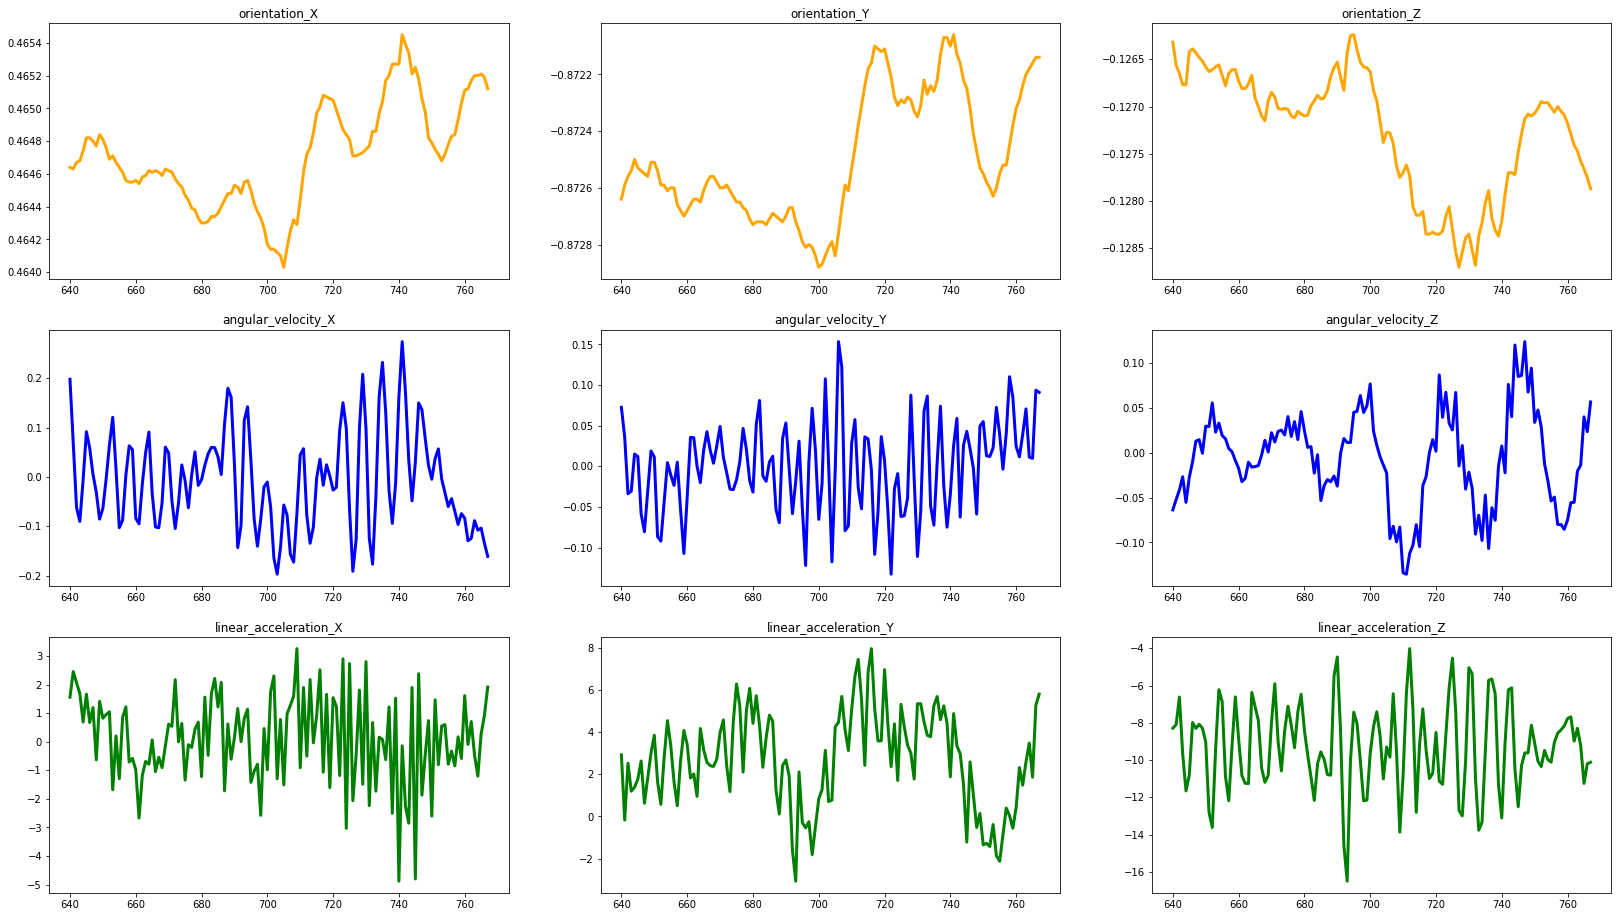

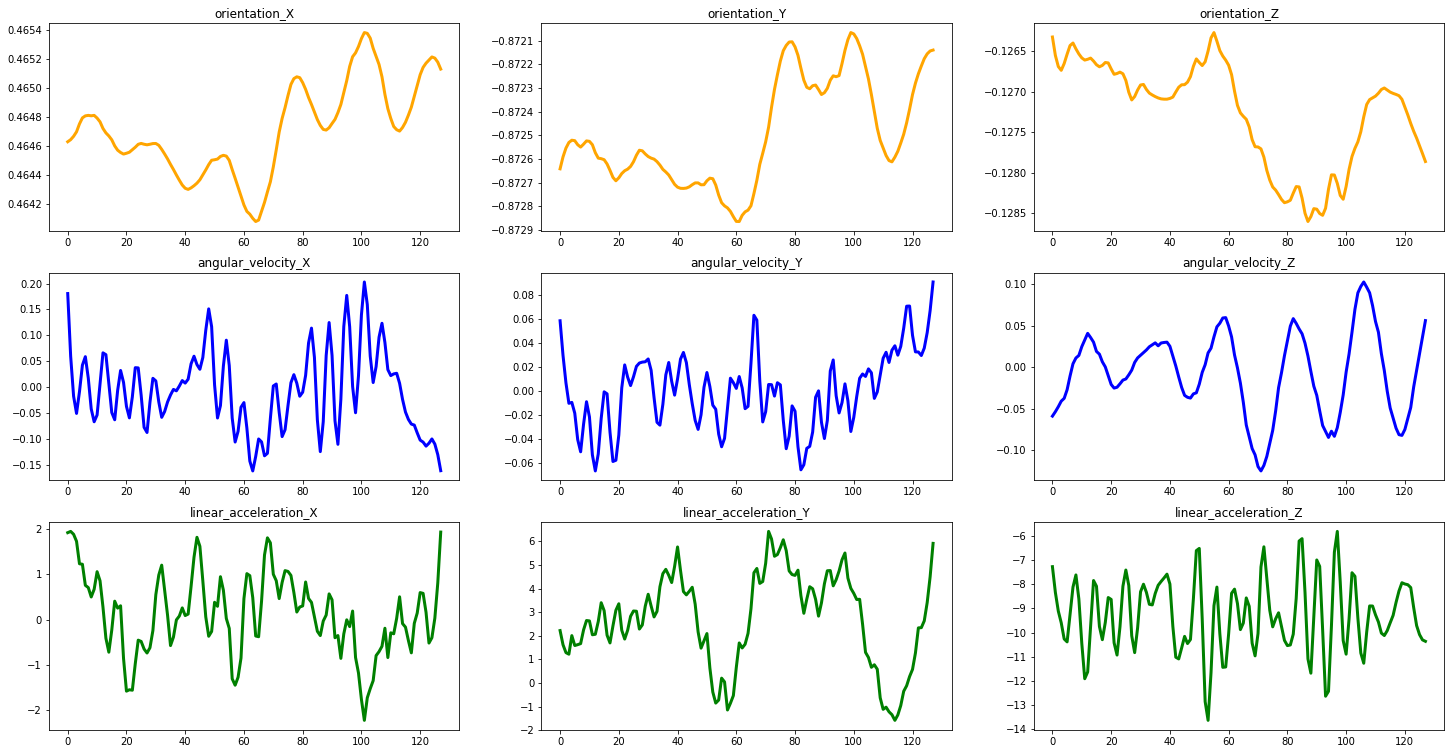

In [11]:


def noiseDetection(series_id):
    
    i = 0
    plt.figure(figsize=(28, 16))
    print('Label is ', y_train[y_train['series_id'] == series_id]['surface'].values[0])
    for col in series_dict[series_id].columns[3:13]:
        if('orientation_W' == col):
            continue
        if ('orientation' in col):
            color = 'orange'
        elif('angular' in col):
            color = 'blue'
        else:
            color = 'green'
        plt.subplot(3,3,i+1)
        plt.plot(series_dict[series_id][col],linewidth = 3,color = color)
        plt.title(col)
        i+=1

        
        
def noiseFreePlot(series_id):
    
    i = 0
    plt.figure(figsize=(25, 13))
    print('Label is ',y_train[y_train['series_id'] == series_id]['surface'].values[0])
    for col in series_dict[series_id].columns[3:13]:
        if('orientation_W' == col):
            continue
        if('orientation' in col):
            color = 'orange'
        elif('angular' in col):
            color = 'blue'
        else:
            color = 'green'
        plt.subplot(3,3,i+1)
        filter_pass = savgol_filter(series_dict[series_id][col],7,2)
        plt.plot(filter_pass,linewidth = 3,color = color)
        plt.title(col)
        i+=1
    
noiseDetection(5)
noiseFreePlot(5)

> As we can see it is now evident the observed noise in the values of features in dataset, which were earlier seen on high level scale.
> This can ruin the training and may cause reduction in training performance.
> We need to filter the noise but retaining the statistical importance of the features.
> I found the article which clearly explains how savgol_filter can help us smooth the data.
> I have shown one series_id plot to visualize the noise in the data and when filtered the data has become quite smooth.

> Savitzky–Golay filter is one of the technique to smooth the data, aka lease-square method. It works on fitting the data using gradient descent and find out best weights that could provide us the estimated smoothed signal.
> More information can be found at : https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

> Referred : https://www.mikulskibartosz.name/smoothing-time-series-in-python-using-savitzky-golay-filter/

> Working :

> * It has two parameters first how many data points will be used to fit a polynomial regression function. The second parameter specifies the degree of the fitted polynomial function. 
> * In every window, a new polynomial is fitted, which gives us the effect of smoothing the input dataset.In every step, the window moves and a different part of the original dataset is used. Then, the local polynomial function is fitted to the data in the window, and a new data point is calculated using the polynomial function. After that, the window moves to the next part of the dataset, and the process repeats.


> This section is about removing noise from the dataset and set it up in the series dict for train and test datasets.
> It also calculates the amount of time required to do this transformation.
> This smoothning is done on both test and train dataset.

In [12]:

import time
print('Filtering for all train and test data')


def filterTrainTestData(series_id,series_dict):
    for col in series_dict[series_id].columns[3:13]:
        filter_pass = savgol_filter(series_dict[series_id][col],7,2)
        series_dict[series_id][col] = filter_pass

        
start = time.time()
for i in X_train['series_id'].unique().tolist():
    #print(f'Series_id {i} for Train is running')
    filterTrainTestData(i,series_dict)
    
end = time.time()   

print(f'Time eclapsed to reduce the noise in Train Data is {(end-start)} secs')

start = time.time()

for j in X_test['series_id'].unique().tolist():
    #print(f'Series_id {j} for Test is running')
    filterTrainTestData(j,series_dictTest)
    
end = time.time()   

print(f'Time eclapsed to reduce the noise in Test Data is  {(end-start)} secs')

Filtering for all train and test data
Time eclapsed to reduce the noise in Train Data is 43.73813986778259 secs
Time eclapsed to reduce the noise in Test Data is  43.076167821884155 secs


> Concating the dictionary to get the denoised data which were computed earlier
> Reason being : As we have filtered the noise and restored the dataframes as per dict_ mappings we need to combine those dataframes to get the whole dataset for next process

In [13]:

train_frames = []
for i in X_train['series_id'].unique():
    train_frames.append(series_dict[i])
    
data_noise_free = pd.concat(train_frames)

test_frames = []

for i in X_test['series_id'].unique():
    test_frames.append(series_dictTest[i])

test_noise_free = pd.concat(test_frames)
print(data_noise_free.shape,test_noise_free.shape)


(487680, 13) (488448, 13)


> Quaternion system is an extension to complex numbers, it can be converted to euler angles to help viewing rotational of objects around x,y,z axis. Quaternion are difficult to understand hence to manipulate in another co-ordinate system is useful.
> Formulas taken from : https://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToEuler/

In [14]:

def quaternion_to_euler(qx,qy,qz,qw):
    
    #x-axis rotation
    #atan2 return the angle theta in range pi to -pi and it's the angle made with positive x axis
    
    sinr_cosp = 2.0 * (qw * qx + qy + qz)
    cosr_cosp = 1.0 - 2.0 * (qx * qx + qy * qy)
    roll = math.atan2(sinr_cosp, cosr_cosp)
    
    # y-axis rotation
    sinp = 2.0 * (qw * qy - qz * qx)
    if(math.fabs(sinp) >= 1):
        pitch = copysign(M_PI/2, sinp)
    else:
        pitch = math.asin(sinp)
        
    #z-axis rotation
    siny_cosp = 2.0 * (qw * qz + qx * qy)
    cosy_cosp = 1.0 - 2.0 * (qy * qy + qz * qz)
    yaw = math.atan2(siny_cosp, cosy_cosp)
    
    return roll, pitch, yaw

> This section converts the quaternion system to euler angles and append this in the train and test dataframe respectively

In [15]:
def eular_angle(data):
    og_x = list(data['orientation_X'].values) 
    og_y = list(data['orientation_Y'].values)
    og_z = list(data['orientation_Z'].values)
    og_w = list(data['orientation_W'].values)
    
    c_x, c_y, c_z = [], [], []
    for i in range(len(og_x)):
        xx, yy, zz = quaternion_to_euler(og_x[i], og_y[i], og_z[i], og_w[i])
        c_x.append(xx)
        c_y.append(yy)
        c_z.append(zz)
    
    data['euler_x'] = c_x
    data['euler_y'] = c_y
    data['euler_z'] = c_z
    
    return data

data = eular_angle(data_noise_free)
test = eular_angle(test_noise_free)
print(data.shape,test.shape)

(487680, 16) (488448, 16)


> In this function, we will add new features to the dataset as this is useful for training models to make their decisions more effectively.
> Reason for adding "Total" is because each of this vectors has directions in different axis, finding magnitude of all three components would make resultant component and that will decide the final motion of the rover.

In [16]:
def Feature_Engineering1(data):
    data['T_angular_velocity'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2) **0.5
    data['T_orientation'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2) ** 0.5
    data['T_linear_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2) ** 0.5
    data['T_angle'] = (data['euler_x']**2 + data['euler_y']**2 + data['euler_z']**2) ** 0.5
    
    return data


data_modified = Feature_Engineering1(data)
test_modified = Feature_Engineering1(test)
print(data_modified.shape,test_modified.shape)

(487680, 20) (488448, 20)


> Reason for adding statistical features to the data we want to consice the dataset.Previously,the datasize was equal to 487k train and 488k test, now we will compute as per series_id and make size 3810 tuples.
> Another reason is to handle the time complexity along with accuracy,so minimizing the training data samples without losing statistical importance is the main agenda of a good machine learning model.

> Median Absolute Deviation is also one of the imp stats other than mean,mean,std,var. It is less affected by outliers because outliers have a smaller effect on the median than they do on the mean. When data is normal, std and mean defines the spreadness very well but when in case of outliers, MAD is robust to use.

In [17]:
def Feature_Engineering2(data):
    df = pd.DataFrame()
    
    for col in data.columns[3:len(data.columns)]:
        per_col_data = data.groupby(['series_id'])[col]
        df[col+'_mean'] = per_col_data.mean()
        df[col+'_median'] = per_col_data.median()
        df[col+'_std'] = per_col_data.std()
        df[col + '_mad'] = data.groupby(['series_id'])[col].apply(lambda x: np.median(np.abs(np.diff(x))))
        df[col+'_var'] = per_col_data.std()**2
    return df


  
compiled_data = Feature_Engineering2(data_modified)
compiled_test = Feature_Engineering2(test_modified)
print(compiled_data.shape,compiled_test.shape) 

        

(3810, 85) (3816, 85)


In [18]:
#Making values numeric for Machine Learning Model to Train on
#Using Label Encoder we can map categories into integer values, this is helpful as numeric values the machine understands pretty well.

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import linear_model
import gc
import xgboost as xgb



In [19]:
#One Hot encoding technique to convert categorical labels into numeric integers.
le = LabelEncoder()
target_label = y_train['surface']
y_train['surface'] = le.fit_transform(y_train['surface'])


#Verbose for mapping labels with encoded value

zipping  = zip(target_label,y_train['surface'].values)
set_zip = set(zipping)
dict_map = {idx : surf for surf,idx in set_zip}
dict_map = sorted(dict_map.items(),key=lambda x : x[1],reverse=False)
print(dict_map)



[(0, 'carpet'), (1, 'concrete'), (2, 'fine_concrete'), (3, 'hard_tiles'), (4, 'hard_tiles_large_space'), (5, 'soft_pvc'), (6, 'soft_tiles'), (7, 'tiled'), (8, 'wood')]


> * Before fitting the model, it's important to know the hyperparamaters to assign that best gives us the optimal accuracy score.
> * Here comes in Play **RandomSearchCv**,because it randomly apply different combinations of params passed and return best accuracy score achieved when applied this combination of parameter. **GridSearchCv** computing time is more and it might be possible some irrelevant feature would be given more importance resulting in **overfitting**.
> * RandomSearch is done using **cross-validation** and number of iterations denotes how many times this process should repeat.
> * **Scoring** is done on bases of **f1_macro** as it calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account but we figured out from plots that classes in y_train are not skewed.

In [20]:
from sklearn.model_selection import RandomizedSearchCV,cross_val_score
from sklearn.metrics import f1_score, make_scorer
from datetime import datetime
import time

In [21]:
#Timer Function is used to calculate time taken for randomsearch cv to fit the data

def timer(startTime=None):
    time_in_secs = (datetime.now()-startTime).total_seconds()
    hour,temp_sec = time_in_secs//3600, time_in_secs%3600
    minute,secs = temp_sec//60, temp_sec % 60
    print(f'Time taken to complete is {hour} hours, {minute} mins and {round(secs,3)} secs')

In [22]:

def bestEstimate(model):
    Xx = compiled_data.values
    Yy = y_train['surface'].values
    model.fit(Xx,Yy)
    
    #Return classifier
    return model

> Uncomment them when you are running for the first time, it takes around 1.5 hr to get complete.
> So I have used pickle to store the model and reload them, which saved our 100% time!!

In [23]:

params_xgb = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
          'max_depth': [7,8,9,10,12],
          'n_estimators':[650,600,550,500],
          'gamma':[0.0,0.1,0.2,0.3,0.4],
          'min_child_weight' : [10,20,30,50,100],
          'objective' : ['multi:softprob']
         }

params_rf = {'max_depth':[8,9,11,10], 
              'min_samples_leaf':[3,9,10,4,5], 
              'min_samples_split':[11,18,21,25],
              'n_estimators':[500,650,600,550],
              'criterion' : ['gini','entropy']}

params_etc = {'max_depth':[7,8,9,10], 
              'min_samples_leaf':[3,9,10,4,5], 
              'min_samples_split':[11,18,21,25],
              'n_estimators':[450,475,550,500],
              'criterion' : ['gini','entropy']}

#Initializing the instances of the classifier
clf_xgb = xgb.XGBClassifier(n_jobs = -1)
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_etc = ExtraTreesClassifier(n_jobs=-1)

#Initial setup for instantiating RandomSearchCv
model_xgb = RandomizedSearchCV(clf_xgb,param_distributions=params_xgb,n_iter=15,scoring='f1_macro',n_jobs=-1,cv=5,verbose=3)
model_rf  = RandomizedSearchCV(clf_rf,param_distributions=params_rf,n_iter=13,scoring='f1_macro',n_jobs=-1,cv=5,verbose=3)
model_etc = RandomizedSearchCV(clf_etc,param_distributions=params_etc,n_iter=15,scoring='f1_macro',n_jobs=-1,cv=7,verbose=3)

#Calculating best params

start_time = datetime.now()
model_rf = bestEstimate(model_rf)
timer(start_time)

start_time = datetime.now()
model_etc = bestEstimate(model_etc)
timer(start_time)

start_time = datetime.now()
model_xgb = bestEstimate(model_xgb)
timer(start_time)

print('Completed')


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed: 10.5min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Time taken to complete is 0.0 hours, 10.0 mins and 50.539 secs
Fitting 7 folds for each of 15 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.8min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Time taken to complete is 0.0 hours, 1.0 mins and 47.114 secs
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 28.5min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Time taken to complete is 0.0 hours, 29.0 mins and 10.437 secs
Completed


Again Uncomment them when running for first time as we write the results in .pickle file

In [24]:
#Pickling helps in save the object in serialized manner and it does this by writing it into word bytes.
#Advantages : Once we got the best model parameters we can save it in this file to avoid re-training the model again
#It reduces the time by 99% as my training time is around ~1.5hrs

import pickle


#Writing to a pickle

random_pickle_out = open('random_clf.pickle','wb')
pickle.dump(model_rf,random_pickle_out)
random_pickle_out.close()

etc_pickle_out = open('etc_clf.pickle','wb')
pickle.dump(model_etc,etc_pickle_out)
etc_pickle_out.close()

xgb_pickle_out = open('xgb_clf.pickle','wb')
pickle.dump(model_xgb,xgb_pickle_out)
xgb_pickle_out.close()


#Reading from a pickle


random_pickle_in = open('random_clf.pickle','rb')
model_r = pickle.load(random_pickle_in)
random_pickle_in.close()

etc_pickle_in = open('etc_clf.pickle','rb')
model_e = pickle.load(etc_pickle_in)
etc_pickle_in.close()


xgb_pickle_in = open('xgb_clf.pickle','rb')
model_x = pickle.load(xgb_pickle_in)
xgb_pickle_in.close()



Kfold cross validation is a technique to overcome overfitting of the data. It's better than other techniques like train_test split or random uniform shuffle.

In [25]:
#Setting up parameters for Kfold Cross Validation

kf = KFold(n_splits = 10,random_state=40,shuffle=True)


#Measured is used for Ensembling Training accuracy results
#Predicted is used for Ensembling Testing samples

predicted = np.zeros((compiled_test.shape[0],9))  #In total there are 9 surfaces
measured= np.zeros((compiled_data.shape[0],3))    #Used for 3 algorithms
score = 0





**RandomForest** - Works on bagging concept where Boostrap data is formed from the original data.
Random subset of variables or the columns are selected and split of the node happens on gini indexes and information gain for chosen variables. When trees are created with defined n_estimator, we then test on unseen tuple which were not in the boostrap data.
It works on Majority voting technique wherein the test_data_samples are made to run on those trees which were not created with those samples and the tree classify the surfaces and out of it the majority vote given to a surface is chosen.

**Advantage of RF:**
* Bias is minimized as the full decision trees are created which results in good model fit.
* Aggregate voting for making decisions.

**XGBoost** - Works similar to AdaBosst and converge using stochastic gradient descent which reduces the error depending on the number of trees to be formed. When incorrectly classified the weight of the feature node is increased and correctly clasified weight is decreased.
This help is taking into account misclassified features and try to correct the mistake.This trees are called stumps and they are weak learners, so after n_estimators of trees formed, the model get better and better, weights get updated and we get good classification model.

**Advantage:**
* Prune the tree reducding the complexity of computing the entropy for the further node
* Invites regularization which kind of help in achieving the accuracy better as it promote weights of less complexity and try to reduce the features of the model.

**Extra Tree:**
* It's also called as Extremely Randomized Tree, it works similar to RF.
* Use unique samples  rather than bootstrap replicas in order to grow the diversify trees. 
* It randomly selects the node and split it randomly too and repeat this step until whole tree is created.
* Total number of features remains the same i.e sqrt(total_features)
* It keeps on building trees as specified hyper paramter "n_estimator"
* Works on majority voting technique for classification.

**Advantage:**
* Faster than all other decision trees and can balance the running time without much losing the accuracy.
* Works well with noise data, though we tried to filter out the noise

**Hyper Parameters explained:**
* min_samples_split = min number of samples required to make a split
* min_samples_leaf = min number of samples required to stop the tree from growing.
* max_depth = max depth of the tree.
* gamma = regularization constant used for pruning the trees in Xgboost
* learning rate/ step_size = how fast you wanna converge used in Xgboost
* min_child_weight = given some weights to the node and then tweak those to improve from weak learners.
* n_jobs = -1 use all cores of the cpu to compute.


> Confusion Matrix : This tells us how our model has performed in terms of classifying the tuples into relevant lables (in our case it's surface)
> With this, we can determine where our model is going wrong to classify and take some necessary measures to improve it.

Starting with Random
Accuracy for fold 0 : 0.8766404199475065
Accuracy for fold 1 : 0.9081364829396326
Accuracy for fold 2 : 0.8976377952755905
Accuracy for fold 3 : 0.8530183727034121
Accuracy for fold 4 : 0.8451443569553806
Accuracy for fold 5 : 0.8556430446194225
Accuracy for fold 6 : 0.8503937007874016
Accuracy for fold 7 : 0.863517060367454
Accuracy for fold 8 : 0.8923884514435696
Accuracy for fold 9 : 0.8766404199475065
Model Random final Training Score is  0.8719160104986876
Starting with XGBoost
Accuracy for fold 0 : 0.9186351706036745
Accuracy for fold 1 : 0.937007874015748
Accuracy for fold 2 : 0.916010498687664
Accuracy for fold 3 : 0.884514435695538
Accuracy for fold 4 : 0.8740157480314961
Accuracy for fold 5 : 0.9002624671916011
Accuracy for fold 6 : 0.9002624671916011
Accuracy for fold 7 : 0.910761154855643
Accuracy for fold 8 : 0.9133858267716536
Accuracy for fold 9 : 0.89501312335958
Model XGBoost final Training Score is  0.9049868766404199
Starting with ExtraTree
Accur

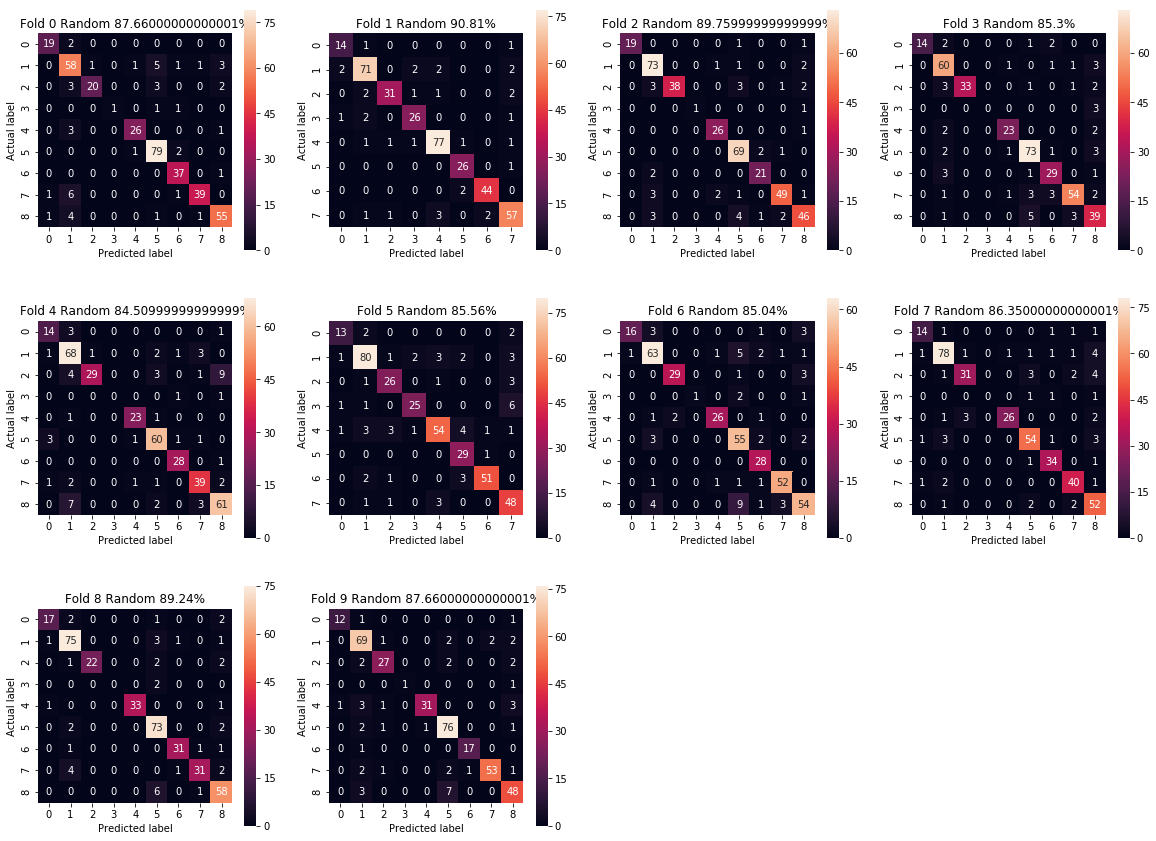

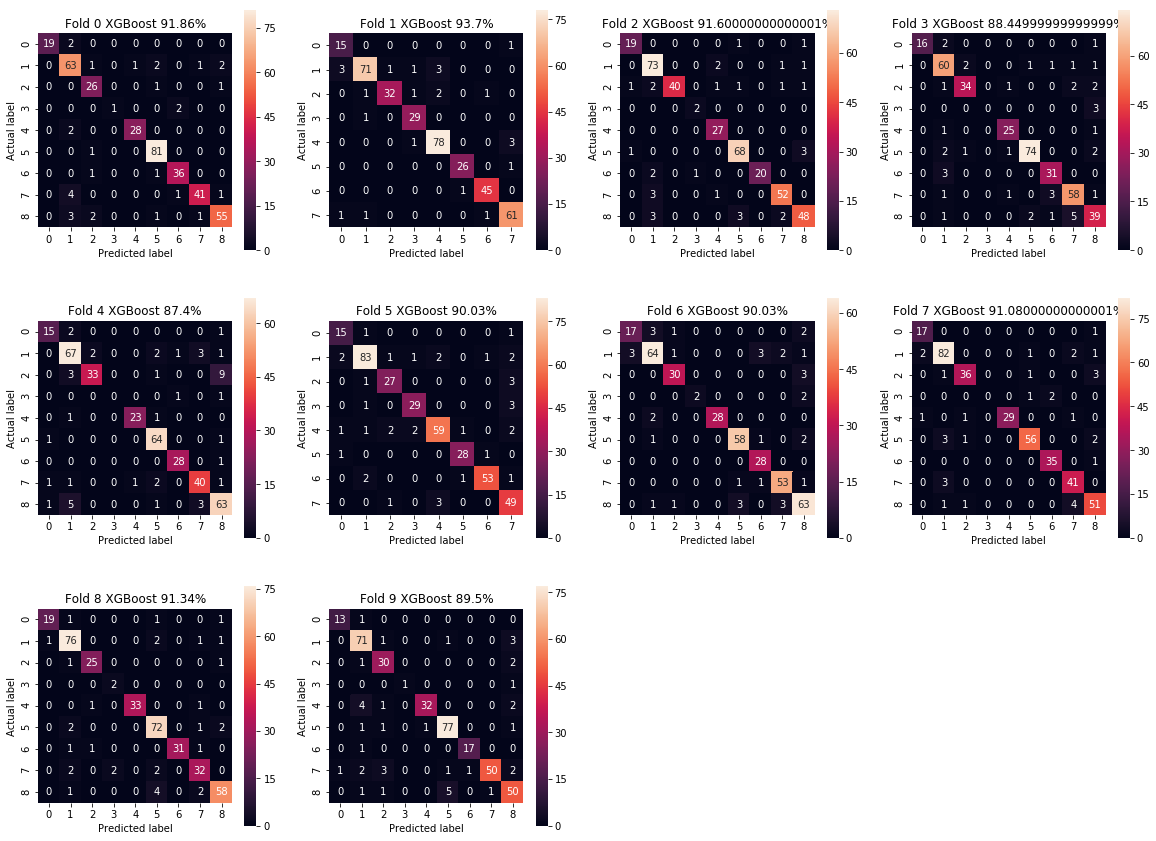

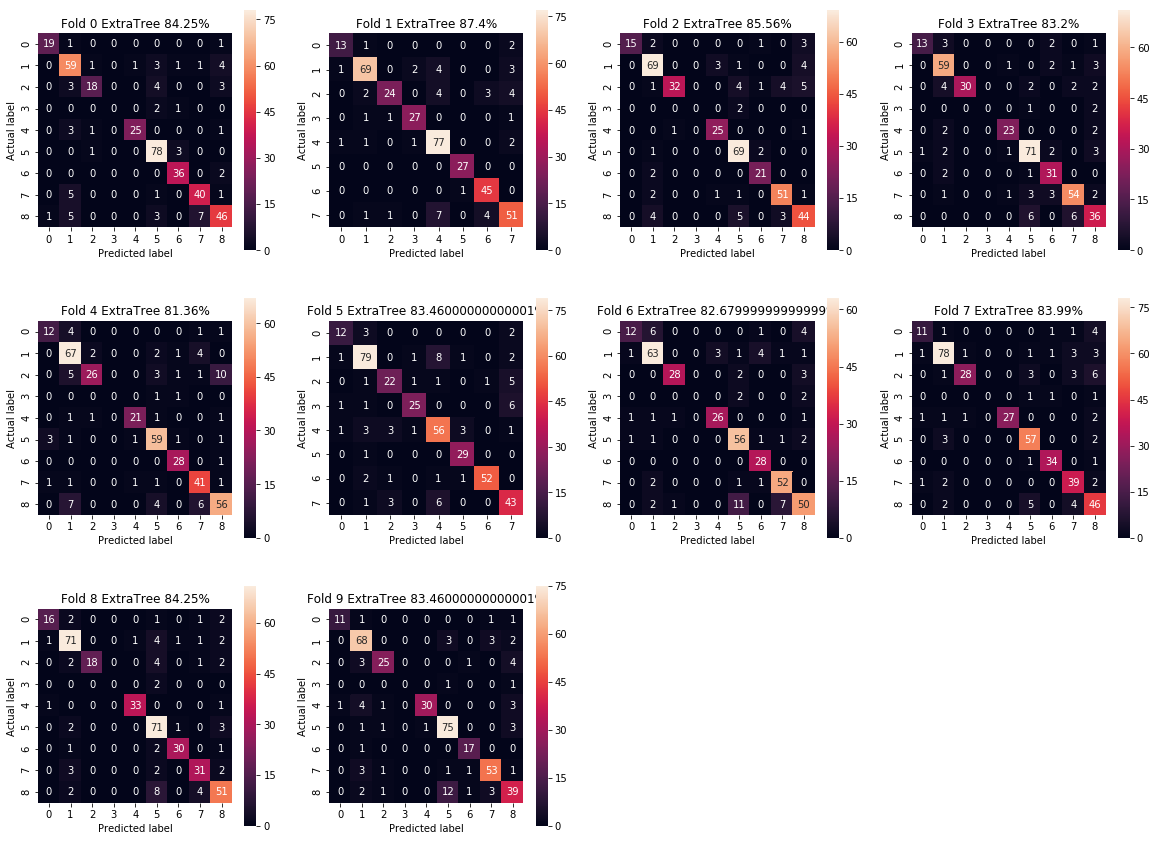

In [26]:

#Training the model and Evaluating the Training accuracy
#Also predicting the unseen tuples 
#Ensembling the results by majority voting techqnique


from sklearn import metrics
df_pred = pd.DataFrame()
algos = ['Random','XGBoost','ExtraTree']
conf_matrix = []

def algoRunner(df_pred,algos,model,model_num): 
    score = 0
    score_calc = []
    
    predicted = np.zeros((compiled_test.shape[0],9))
    print(f'Starting with {algos[model_num]}')
    i = 0
    for times,(train_index, test_index) in enumerate(kf.split(compiled_data.values,y_train['surface'].values)):
        X_train,X_test = compiled_data.iloc[train_index],compiled_data.iloc[test_index]
        y_train1,y_test = y_train['surface'][train_index],y_train['surface'][test_index]
        
        #Fitting the model as we have now the best hypertunning parameter to train the data
        
        model.fit(X_train,y_train1)
        y_pred = model.predict(X_test)
        conf_matrix.append(metrics.confusion_matrix(y_test, y_pred))
        
        #Inserting the prediction column wise in measure numpy array of size (3816,3)

        measured[test_index,model_num] = y_pred
        score += model.score(X_test,y_test)
        score_calc.append(model.score(X_test,y_test))
        print(f'Accuracy for fold {times} : {score_calc[times]}')
        
        #Making predictions on unseen data samples, predict_proba will return the list of probabilities  
        predicted += model.predict_proba(compiled_test)/kf.n_splits

    #Confusion matrix for each fold validation
    
    plt.figure(figsize=(20,15))
    for i in range(len(conf_matrix)):
        plt.subplot(3,4,i+1)
        plt.title(f'Fold {i} {algos[model_num]} {round(score_calc[i],4)*100}%')
        sns.heatmap(conf_matrix[i], annot=True, square = True)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
    score_calc.clear() 
    conf_matrix.clear()
    #In 10 fold, the prediction done on unseen data is calculated and it has stored in dataframe called df_pred
    
    df_pred[algos[model_num]] = predicted.argmax(axis=1)
    print(f'Model {algos[model_num]} final Training Score is ',score/kf.n_splits)
    
    #Garbage collector is used to free up space.
    gc.collect()
    

#Without using RandomSearch I previously applied to the best of my knowledge the estimated guess for models

#model_rf = RandomForestClassifier(n_estimators = 700,n_jobs=-1,max_depth = 10,min_sample_split = 20, min_leaf_split = 7)
#model_xgb = xgb.XGBClassifier(objective = "multi:softprob", max_depth = 10, n_estimators = 700, learning_rate = 0.2, gamma = 0.4,min_child_weight = 50, nthread = -1, seed = 0)
#model_etc = ExtraTreesClassifier(n_estimators = 700, max_depth = 10,random_state = 0,max_features = 10)

#Calculated earlier from RandomSearchCv
model_rf_ = model_r.best_estimator_
model_xgb_ = model_x.best_estimator_
model_etc_ = model_e.best_estimator_


#Running the algos with RandomSearch optimization
algoRunner(df_pred,algos,model_rf_,0)
algoRunner(df_pred,algos,model_xgb_,1)
algoRunner(df_pred,algos,model_etc_,2)
    

> Using K-Fold Cross Validation we can see how each model has predicted the surface
> We can ensemble the results and check whether we can do better in training accuracy
> As XGBoost performed well on y_test, this is just an attempt to combine three model prediction and use them to derive result


In [27]:

from collections import Counter

#print(df_pred.shape)
#df_pred.drop(columns = ['Ensemble_Result','Actual'],axis=1,inplace=True)

def ensemblePredictions(df_measured,type_):
    df_measured.columns = ['Random','XGBoost','ExtraTree']

    lst = []
    for i in range(df_measured.shape[0]):
        c = Counter(df_measured.iloc[i,:]).most_common(1)
        for pred,count in c:
            lst.append(pred)

    df_measured['Ensemble_Result'] = pd.Series(lst)
    
    #We know the label for training i.e y_train after ensembling the models we are computing the accuracy
    
    if(type_ == 'training'):
        df_measured['Actual'] = pd.Series(y_train['surface'].values)
        wrong_pred = np.array(df_measured['Actual'] - df_measured['Ensemble_Result'])
        print(((df_measured.shape[0] - np.count_nonzero(wrong_pred))/df_measured.shape[0] ))
    
    
ensemblePredictions(pd.DataFrame(measured),'training')
ensemblePredictions(df_pred,'testing')


0.8763779527559055


> Yes we did approx **1% **better by ensembling the models on RF and ETC algos but we curtailed XGboost Prediction :(

> Let us look at the one of the decision tree generated by Random Forest and ExtraTree to know the importance of the features which are set as decision making parameters in the tree.
> Graphviz is the library which help us getting the .dot file where all the manual rules of decision are written over
> Pydot libary will help us interpreting the dot file and graphing out in graph form which is further saved as a png file

In [28]:
from sklearn.tree import export_graphviz
import pydot

def plotTree(model,algo):
    one_tree = model.estimators_[4]  #Getting the 400th tree
    features_list = compiled_data.columns.tolist()
    export_graphviz(one_tree, out_file = f'one_tree_{algo}.dot', feature_names = features_list, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_file(f'one_tree_{algo}.dot')
    graph.write_png(f'tree_{algo}.png')
    
    
plotTree(model_rf_,"RandomForest")
plotTree(model_etc_,"ETC")

> Finally, I converted the encoded labels into orginal surface names and saved it in submission.csv file.
> I have also plotted which surface has been predicted and their counts.

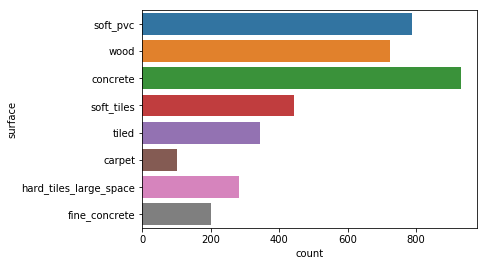

In [29]:

y_final = le.inverse_transform(df_pred['Ensemble_Result'])
compiled_test['surface'] = y_final
sns.countplot(y='surface',data=compiled_test)
compiled_test['surface'].to_csv('submission.csv',header=True,encoding='utf-8',index=True)


>  **Resources:**<br>
>  XGBoost Explaination:<br> 
https://www.youtube.com/watch?v=9CPsYsB4OLI<br>
https://www.youtube.com/watch?v=LsK-xG1cLYA&t=210s<br>
https://www.youtube.com/watch?v=jxuNLH5dXCs<br>

>  ExtraTree Classifier:<br>
Pierre G, Damien E, Louis W (2006) Extremely Randomized Trees. In: Springer Science Journal doi:10.1007/s10994-006-6226-1    
https://www.youtube.com/watch?v=Q1qpG7gwix4<br>

>  RandomSearchCv: <br>
https://www.youtube.com/watch?v=Ah4wsTXghwI&list=UU8ofcOdHNINiPrBA9D59Vaw&index=21 <br>                                                 https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html <br>
                     
> Quaternion to Euler: <br>
https://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToEuler/ <br>

>   Savgol_Filter: <br>
https://www.mikulskibartosz.name/smoothing-time-series-in-python-using-savitzky-golay-filter/ <br>
     
>  Kernels referred: <br>
https://www.kaggle.com/hiralmshah/robot-sensor-eda-fe-and-prediction-improvement
